### FCTV (Temporal Variability of Connectivity)

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, pearsonr

# -------------------------------
# Configuration
# -------------------------------
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
PARTICIPANTS_CSV = os.path.join(BASE_DIR, "participants.csv")
BANDS = ["theta", "alpha"]
WINDOW_FOLDER = "data"
MOCA_THRESHOLD = 26

# -------------------------------
# Load participants
# -------------------------------
df = pd.read_csv(PARTICIPANTS_CSV, dtype={"participant_id": str})
df.set_index("participant_id", inplace=True)

moca_col = "MOCA" if "MOCA" in df.columns else "MoCA"
if moca_col not in df.columns:
    raise ValueError("MOCA column not found in participants CSV")

pd_df = df[df["GROUP"].str.upper() == "PD"].copy()
subjects = pd_df.index.tolist()

# -------------------------------
# Feature extraction functions
# -------------------------------
def compute_fctv(pli_windows):
    return np.std(pli_windows, axis=0)

def compute_temporal_corr(pli_windows):
    """Mean correlation between consecutive windows; returns np.nan if undefined"""
    n_win = pli_windows.shape[0]
    if n_win < 2:
        return np.nan  # Not enough windows to correlate
    corrs = []
    for i in range(n_win - 1):
        v1 = pli_windows[i].flatten()
        v2 = pli_windows[i + 1].flatten()
        # Skip pairs with zero variance
        if np.std(v1) == 0 or np.std(v2) == 0:
            continue
        corrs.append(np.corrcoef(v1, v2)[0, 1])
    if len(corrs) == 0:
        return np.nan
    return np.mean(corrs)


def compute_electrode_variability(pli_windows):
    """Variability per electrode across all connections and time"""
    n_ch = pli_windows.shape[1]
    var_list = []
    for ch in range(n_ch):
        conn_vals = pli_windows[:, ch, :].copy()
        # Remove self-connections only if matrix is square
        if pli_windows.shape[2] >= n_ch:
            conn_vals[:, ch] = np.nan
        var_list.append(np.nanmean(np.std(conn_vals, axis=0)))
    return np.array(var_list)


# -------------------------------
# Loop over subjects and bands
# -------------------------------
all_results = []

for subj in subjects:
    subj_data_folder = os.path.join(BASE_DIR, subj, WINDOW_FOLDER)
    for band in BANDS:
        pli_file = os.path.join(subj_data_folder, f"{subj}_{band}_pli_windows.npy")
        if not os.path.exists(pli_file):
            print(f"{subj} {band}: PLI windows not found, skipping")
            continue

        pli_windows = np.load(pli_file)
        if pli_windows.ndim != 3:
            print(f"{subj} {band}: invalid shape {pli_windows.shape}, skipping")
            continue

        fctv = compute_fctv(pli_windows)
        temporal_corr = compute_temporal_corr(pli_windows)
        electrode_var = compute_electrode_variability(pli_windows)

        all_results.append({
            "subject": subj,
            "band": band,
            "FCTV_mean": np.nanmean(fctv),
            "TemporalCorr": temporal_corr,
            "ElectrodeVar_mean": np.nanmean(electrode_var),
            "ElectrodeVar_max": np.nanmax(electrode_var),
            "MOCA": pd_df.at[subj, moca_col]
        })

# -------------------------------
# Convert to DataFrame
# -------------------------------
df_feat = pd.DataFrame(all_results)
df_feat["impaired"] = df_feat["MOCA"] < MOCA_THRESHOLD

# -------------------------------
# Statistical testing
# -------------------------------
for band in BANDS:
    sub = df_feat[df_feat["band"] == band]
    impaired = sub[sub["impaired"]]
    unimpaired = sub[~sub["impaired"]]

    print(f"\n--- {band.upper()} band ---")
    for feat in ["FCTV_mean", "TemporalCorr", "ElectrodeVar_mean", "ElectrodeVar_max"]:
        if len(impaired) >= 3 and len(unimpaired) >= 3:
            t_stat, p_val = ttest_ind(impaired[feat], unimpaired[feat], equal_var=False)
            r, p_corr = (pearsonr(sub[feat], sub["MOCA"]) if len(sub) >= 4 else (np.nan, np.nan))
            print(f"{feat}: t={t_stat:.3f}, p={p_val:.6g} | r={r:.3f}, p_corr={p_corr:.6g}")



--- THETA band ---
FCTV_mean: t=0.101, p=0.919647 | r=-0.123, p_corr=0.22324
TemporalCorr: t=-2.209, p=0.0295459 | r=0.285, p_corr=0.00411253
ElectrodeVar_mean: t=0.101, p=0.919647 | r=-0.123, p_corr=0.22324
ElectrodeVar_max: t=-0.113, p=0.910252 | r=-0.081, p_corr=0.420442

--- ALPHA band ---
FCTV_mean: t=-0.792, p=0.430497 | r=0.113, p_corr=0.2644
TemporalCorr: t=-1.319, p=0.190205 | r=0.132, p_corr=0.190358
ElectrodeVar_mean: t=-0.792, p=0.430497 | r=0.113, p_corr=0.2644
ElectrodeVar_max: t=-0.669, p=0.504969 | r=0.107, p_corr=0.287411


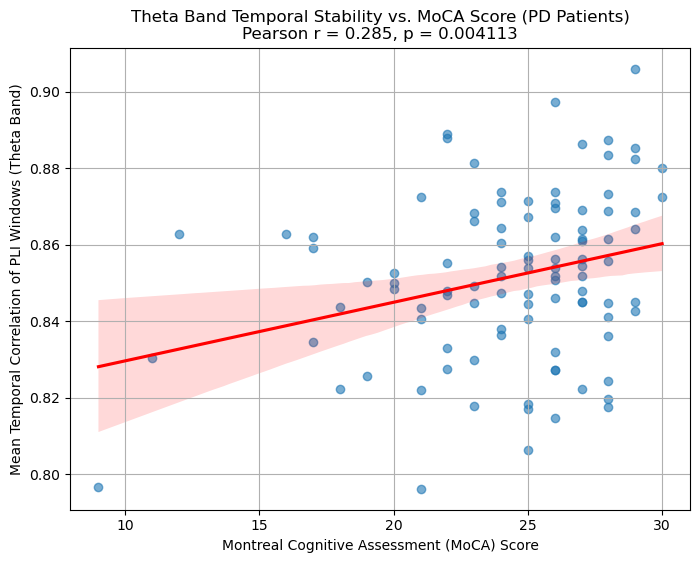

In [2]:
# -------------------------------
# Statistical Visualization: Theta Temporal Correlation vs. MoCA
# -------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Filter the data specifically for the 'theta' band
theta_data = df_feat[df_feat["band"] == "theta"].copy()

# Calculate the correlation for the plot title
r_val, p_val = pearsonr(theta_data["TemporalCorr"], theta_data["MOCA"])

# Create the plot
plt.figure(figsize=(8, 6))
sns.regplot(x="MOCA", y="TemporalCorr", data=theta_data, 
            scatter_kws={'alpha':0.6}, line_kws={"color":"red"})

# Add title and labels
plt.title(f"Theta Band Temporal Stability vs. MoCA Score (PD Patients)\nPearson r = {r_val:.3f}, p = {p_val:.4g}")
plt.xlabel("Montreal Cognitive Assessment (MoCA) Score")
plt.ylabel("Mean Temporal Correlation of PLI Windows (Theta Band)")
plt.grid(True)
plt.show()


### Asymetry index and complexity connectivity correlation

In [3]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, pearsonr

# -------------------------------
# CONFIG
# -------------------------------
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
PARTICIPANTS_CSV = os.path.join(BASE_DIR, "participants.csv")
BANDS = ["theta", "alpha"]
WINDOW_FOLDER = "data"
MOCA_THRESHOLD = 26

CH_NAMES = ['Fp1','Fz','F3','F7','Iz','FC5','FC1','C3','T7','TP9','CP5','CP1','P3','P7','O1','Oz','O2',
            'P4','P8','TP10','CP6','CP2','Cz','C4','T8','FT10','FC6','FC2','F4','F8','Fp2','AF7','AF3','AFz',
            'F1','F5','FT7','FC3','C1','C5','TP7','CP3','P1','P5','PO7','I1','POz','I2','PO8','P6','P2','CPz',
            'CP4','TP8','C6','C2','FC4','FT8','F6','AF8','AF4','F2','FCz']

LEFT_CH = ['F5', 'AF3', 'F7', 'F3']
RIGHT_CH = ['F4', 'F6', 'AF4', 'F8']

# -------------------------------
# HELPERS
# -------------------------------
def ensure_square(data):
    if data.ndim == 3 and data.shape[-1] == 1:
        data = data.squeeze(-1)
    if data.ndim == 2:
        data = data[None, ...]
    return data  # (W, C, C)

def get_idx(ch_list, roi):
    return [i for i, ch in enumerate(ch_list) if ch in roi]

def hemispheric_variance_asym(pli_windows, l_idx, r_idx):
    if len(l_idx) < 2 or len(r_idx) < 2:
        return np.nan

    left_vals = pli_windows[:, l_idx, :][:, :, l_idx].ravel()
    right_vals = pli_windows[:, r_idx, :][:, :, r_idx].ravel()

    var_l = np.nanvar(left_vals)
    var_r = np.nanvar(right_vals)

    return (var_r - var_l) / (var_r + var_l + 1e-12)

# -------------------------------
# LOAD PARTICIPANTS
# -------------------------------
df = pd.read_csv(PARTICIPANTS_CSV, dtype={"participant_id": str})
df["sid"] = df["participant_id"].str.replace("sub-", "")
df.set_index("sid", inplace=True)

pd_df = df[df["GROUP"].str.upper() == "PD"]
results = []

# -------------------------------
# MAIN LOOP
# -------------------------------
for sid in pd_df.index:
    subj = f"sub-{sid}"
    folder = os.path.join(BASE_DIR, subj, WINDOW_FOLDER)

    for band in BANDS:
        f = os.path.join(folder, f"{subj}_{band}_pli_windows.npy")
        if not os.path.exists(f):
            continue

        pli = ensure_square(np.load(f))
        n_ch = pli.shape[-1]
        ch_list = CH_NAMES[:n_ch]

        l_idx = get_idx(ch_list, LEFT_CH)
        r_idx = get_idx(ch_list, RIGHT_CH)

        var_asym = hemispheric_variance_asym(pli, l_idx, r_idx)

        results.append({
            "subject": subj,
            "band": band,
            "VarAsym": var_asym,
            "MOCA": pd_df.at[sid, "MOCA"]
        })

# -------------------------------
# STATS
# -------------------------------
df_feat = pd.DataFrame(results).dropna()
df_feat["impaired"] = df_feat["MOCA"] < MOCA_THRESHOLD

for band in BANDS:
    sub = df_feat[df_feat["band"] == band]

    t, p = ttest_ind(
        sub[sub["impaired"]]["VarAsym"],
        sub[~sub["impaired"]]["VarAsym"],
        equal_var=False
    )

    r, pr = pearsonr(sub["VarAsym"], sub["MOCA"])

    print(f"\n--- {band.upper()} ---")
    print(f"Variance Asym Group Diff: p={p:.4f}")
    print(f"Correlation with MoCA: r={r:.3f}, p={pr:.4f}")



--- THETA ---
Variance Asym Group Diff: p=0.6574
Correlation with MoCA: r=0.101, p=0.3165

--- ALPHA ---
Variance Asym Group Diff: p=0.7787
Correlation with MoCA: r=0.085, p=0.3977
